In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict

import scipy as sp

from scipy.stats import spearmanr, kendalltau
from sklearn.exceptions import ConvergenceWarning
import seaborn as sns
np.set_printoptions(precision=4, suppress=True)

from collections import Counter
from tqdm import tqdm_notebook
from itertools import chain
from collections import defaultdict
import os

figsize = (15,8)
legend_fontsize = 16

In [ ]:
import json, pickle

tournaments = pickle.load(open('chgk/tournaments.pkl', 'rb'))
results_main = pickle.load(open('chgk/results.pkl', 'rb'))
players = pickle.load(open('chgk/players.pkl', 'rb'))

In [ ]:
results = dict(results_main)

# Chapter 1 : data filtering

1. Split data into train/test according to year (2019/2020).  
2. Filter corrupted data: missing teams or results.  

In [ ]:
train_tournaments = {k: v for k,v in tournaments.items() if v['dateStart'][:4] == '2019'}
test_tournaments = {k: v for k,v in tournaments.items() if v['dateStart'][:4] == '2020'}

print(f'Number of TRAIN tournaments: {len(train_tournaments)}')
print(f'Number of TEST tournaments: {len(test_tournaments)}')

In [ ]:
def filter_empty(tours, results):
    to_remove = []
    for k, v in tours.items():
        teams = results[k]
        if len(teams) == 0:
            to_remove.append(k)
        else:
            teams_missing = []
            teams = results[k]
            if len(teams) <= 1: # single team game
                to_remove.append(k)
            else:
                for idx, team in enumerate(teams):
                    if team.get('mask', None) is None or len(team['mask']) == 0 or len(team['teamMembers']) == 0:
                        teams_missing.append(idx)
                if len(teams_missing) == len(teams): # all teams information is missing
                    to_remove.append(k)
                else:
                    # (!) modifies initial data (!)
                    results[k] = [t for idx, t in enumerate(teams) if idx not in teams_missing]

    for k in to_remove:
        del tours[k]

In [ ]:
for name, tours in zip(['TRAIN', 'TEST'], [train_tournaments, test_tournaments]):
    old_len = len(tours)
    print(f'Filtering {name} tournaments')
    filter_empty(tours, results)
    print(f'Length of {name} before: {old_len}; after filtering: {len(tours)}')
    print('---' * 4)

train_keys = set(train_tournaments.keys())
test_keys = set(test_tournaments.keys())

keys = train_keys.union(test_keys)
results = {k: results[k] for k in keys}

## Data transformation

- Team based stats  
- Player based stats (team stat unwrapped per team player)  


In [7]:
def results_to_team_stats(results):
    team_stats = []
    for tour_idx, result in results.items():
        for local_idx, team in enumerate(result):
            team_dict = team['team']
            team_id = team_dict['id']
            team_name = team_dict['name']
            mask = team['mask']
            positive = team['questionsTotal']
            negative = len(mask) - positive
            total = len(mask)
            position = team['position']
            members = []
            for member in team['teamMembers']:
                old_rating = member['usedRating']
                new_rating = member['rating']
                player_id = member['player']['id']
                struct = (player_id, old_rating, new_rating)
                members.append(struct)
            team_struct = (tour_idx, team_id, team_name, mask, positive, negative, total, position, members)
            team_stats.append(team_struct)
    return team_stats

In [8]:
def attach_question_levels_to_df(df, question_levels):
    assert all(col in df.columns for col in ['mask'])
    
    new_cols = ['1', '2', 'rest', '1_correct', '2_correct', 'rest_correct']
    target_levels = [1, 2, 'rest']
    
    new_columns = []
    for idx, mask in df['mask'].iteritems():
        levels = question_levels[idx]
        
        row = [levels[level] for level in target_levels]
        from_until = [0]
        for item in row:
            new_idx = from_until[-1] + item
            from_until.append(new_idx)
        
        correct_answers = []
        for level_prev, level_next in zip(from_until[:-1], from_until[1:]):
            correct_answer = mask[level_prev:level_next].count('1')
            correct_answers.append(correct_answer)
        
        row_with_answers = row + correct_answers
        new_columns.append(row_with_answers)
        
    new_columns = pd.DataFrame(new_columns, columns=new_cols, index=df.index)
    return pd.concat([df, new_columns], axis=1)

In [9]:
question_levels = defaultdict(lambda: defaultdict(lambda: 0))
for tour in chain(train_tournaments.values(), test_tournaments.values()):
    idx = tour['id']
    questions = tour['questionQty']
    for level, quantity in questions.items():
        level = int(level)
        question_levels[idx][level] = quantity
        if level >= 3: # consider questions from 3rd and after level - `rest`;
            question_levels[idx]['rest'] += quantity
    
    
dict(question_levels[4772])

{1: 12, 2: 12, 3: 12, 'rest': 12}

In [10]:
team_stats = results_to_team_stats(results)
columns = ['tournament_id', 'team_id', 'team_name', 'mask', 'positive', 'negative', 'total', 'position', 'members']
teams_df = pd.DataFrame(team_stats, columns=columns)
teams_df.index = teams_df.tournament_id

In [11]:
teams_df = attach_question_levels_to_df(teams_df, question_levels)

In [12]:
teams_df[teams_df.tournament_id == 5753].head(3)

,tournament_id,team_id,team_name,mask,positive,negative,total,position,members,1,2,rest,1_correct,2_correct,rest_correct
tournament_id,,,,,,,,,,,,,,,
5753,5753,48583,Цветы,111101111111111111111111111111111111,35,1,36,1.0,"[(72211, 13629, 13629), (10695, 11283, 13540),...",12,12,12,11,12,12
5753,5753,49225,Команда Игоря Пятова,111111111111111111110111111111110111,34,2,36,2.0,"[(57032, 12161, 12161), (51715, 9847, 11816), ...",12,12,12,12,11,11
5753,5753,4032,X-promt,111111111011111111110111111011111111,33,3,36,7.5,"[(5007, 11514, 11514), (7737, 9595, 11514), (2...",12,12,12,11,11,11


In [13]:
def team_stats_to_player_stats(df):
    columns = ['tournament_id', 'team_id', 'mask', 'positive', 'negative',
       'total', '1', '2', 'rest', '1_correct',
       '2_correct', 'rest_correct', 'members', 'player_id', 'old_rating', 'new_rating']
    
    subdf = df[columns[:-3]].reset_index(drop=True)
    exploded = subdf['members'].explode()
    subdf.drop(columns=['members'], inplace=True)
    members = pd.DataFrame(list(exploded), columns=columns[-3:], index=exploded.index)
    
    return members.join(subdf)

In [40]:
participant_df = team_stats_to_player_stats(teams_df)

In [41]:
mask = participant_df.tournament_id.isin(train_keys)
train_participant_df = participant_df[mask]
test_participant_df = participant_df[~mask]
assert not train_participant_df.tournament_id.isin(test_keys).any()
assert not test_participant_df.tournament_id.isin(train_keys).any()
print(train_participant_df.shape, test_participant_df.shape)

(451776, 15) (112834, 15)


In [42]:
# no need in ratings
train_participant_df.drop(columns=['old_rating', 'new_rating'], inplace=True)
test_participant_df.drop(columns=['old_rating', 'new_rating'], inplace=True)

In [17]:
train_participant_df.sample(5)

,player_id,tournament_id,team_id,mask,positive,negative,total,1,2,rest,1_correct,2_correct,rest_correct
85932,8103,5838,575,111001000111111110100111111010011100,23,13,36,12,12,12,7,9,7
40221,20640,5516,3156,011110001100111111000100111000101010,19,17,36,12,12,12,6,7,6
70583,104732,5760,72474,1110101110000110111011000111001111011111111110...,52,20,72,36,36,72,22,30,0
61105,24934,5729,46319,011111111101101011101110111101010010,25,11,36,12,12,12,10,8,7
54273,198132,5700,71413,110001001000000010001000000000000001,7,29,36,12,12,12,4,2,1


## Tournaments and results study

In [18]:
stats = defaultdict(lambda: 0)
for tour in chain(train_tournaments.values(), test_tournaments.values()):
    questions = tour['questionQty']
    for k, v in questions.items():
        k = int(k)
        stats[k] += v
        stats[f'{k}_count'] += 1

n_items = len(stats) // 2
flatten = [(stats[idx], stats[f'{idx}_count']) for idx in range(1, n_items + 1)]

In [19]:
means = np.array(flatten)
repeats = means[:, 1]
means = means[:, 0] / means[:, 1]

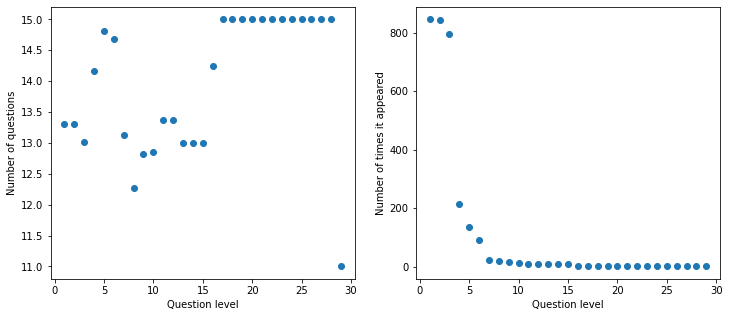

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].scatter(range(1, n_items+1), means)
axs[0].set(xlabel='Question level')
axs[0].set(ylabel='Number of questions')

axs[1].scatter(range(1, n_items+1), repeats)
axs[1].set(xlabel='Question level')
axs[1].set(ylabel='Number of times it appeared')

plt.show()

In [21]:
del means
del repeats
del flatten

In [23]:
teams_df[['team_name', 'position']] \
            .groupby('team_name').agg(['min', 'max', 'count']) \
            .sort_values(by=('position', 'count'), ascending=False)
            

position             
                          min    max count
team_name                                 
МГТУ - Легионеры          1.0  729.5   305
Губы Дзюбы                1.0  727.0   255
Чефирный эксперимент      1.5  603.0   216
Кондуктор понимает        2.0  353.5   189
Кудрявчик и Вахривка      1.0  637.5   186
...                       ...    ...   ...
Поза з Аликом            58.5   58.5     1
Поза Люксембург          48.0   48.0     1
Дядя Дима               479.0  479.0     1
Дятлы                   185.5  185.5     1
Лисы Арктики             60.0   60.0     1

[11984 rows x 3 columns]

# Chapter 2 & 3: baseline model

## Baseline №1. Player ranking

### Idea №1.  

1. For each player, collect statistics about his/her performance per question level.   
2. The statistics per question are taken from team results per tournament, it is expanded for each participant of a team. As long as we apply it for every player in every team in every tournament, it is okay.    
3. For the purpose of simplicity questions are divided into 3 levels: 1st, 2nd, and 3rd+ (3rd, 4th, etc.).  
4. Average over all tournaments the probabilities of each player and receive a vector of gains `(power1, power2, power3)`. It does not take into account the difficulty of concrete tournament, the `number of players` in a team, the `number of tournaments` a player participated in. The normalization will be done via 2 terms stated earlier.    

### Idea №2.  

Continue the previous idea with focus on 4th step: another normalization technique will be involved for averaging (weighted (?)).  


### Team ranking

Taking the vector of gains from `player rankings`, we may end up with a team vector gains (simple sum or average).  

In [25]:
train_participant_df.sample(3)

,player_id,tournament_id,team_id,mask,positive,negative,total,1,2,rest,1_correct,2_correct,rest_correct
5015,215460,6249,76543,100000000100010100000010000100000000,6,30,36,36,36,180,6,0,0
45265,18112,5572,37782,01X0110001011100110111100X0011110111111110,25,17,42,14,14,14,7,6,12
80877,141526,5819,60247,1111001101110010010000110X0000000001,14,22,36,12,12,12,9,4,1


In [26]:
def group_probabilities(group, cols=['prob', '1_prob', '2_prob', 'rest_prob', 'games', 'total_positive', 'total_questions']):
    total_positive = group['positive'].sum()
    total_questions = group['total'].sum()
    correct_prob = total_positive / total_questions
    correct_1_prob = group['1_correct'].sum() / group['1'].sum()
    correct_2_prob = group['2_correct'].sum() / group['2'].sum()    
    correct_rest_prob = group['rest_correct'].sum() / group['rest'].sum()  
    games = len(group)
    row = [correct_prob, correct_1_prob, correct_2_prob, correct_rest_prob, games, total_positive, total_questions]
    
    return pd.Series(row, index=cols)

In [27]:
players_probabilities = train_participant_df.groupby('player_id').apply(group_probabilities)
players_probabilities.describe()

,prob,1_prob,2_prob,rest_prob,games,total_positive,total_questions
count,59101.000000,59101.000000,59101.000000,58791.000000,59101.000000,59101.000000,59101.000000
mean,0.337794,0.361653,0.297358,0.260472,7.644135,153.797076,355.561073
std,0.161992,0.178223,0.179150,0.182968,14.614473,339.306396,644.405209
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,24.000000
25%,0.216667,0.240000,0.166667,0.111111,1.000000,13.000000,36.000000
50%,0.333333,0.361111,0.294872,0.250000,2.000000,34.000000,108.000000
75%,0.456853,0.500000,0.416667,0.380952,6.000000,124.000000,324.000000
max,0.972222,1.000000,1.000000,1.000000,227.000000,5742.000000,9195.000000


In [28]:
from collections import namedtuple
Team = namedtuple('Team', ['team_id', 'position', 'player_ids'])

def get_tournament_orders(df):
    tournament_teams = defaultdict(lambda: defaultdict(dict))
    assert all(col in df.columns for col in ['tournament_id', 'team_id', 'members', 'position'])

    for tournament_id, team_id, members, position in df[['tournament_id', 'team_id', 'members', 'position']].itertuples(index=None, name=None):
        player_ids = [member[0] for member in members]
        team = Team(team_id, position, player_ids)
        tournament_teams[tournament_id]['teams'][team_id] = team

    for v in tournament_teams.values():
        positions = []
        for team in v['teams'].values():
            pair = team.team_id, team.position
            positions.append(pair)
        positions.sort(key=lambda x: x[1])
        order, positions = list(zip(*positions))
        v['order'] = order
        v['position'] = positions
    return tournament_teams

In [29]:
tournament_teams = get_tournament_orders(teams_df)
print('Top 10 teams of tournament 4722', tournament_teams[4772]['order'][:10])
print('Player ids of team 45556', tournament_teams[4772]['teams'][45556].player_ids)

Top 10 teams of tournament 4722 (45556, 1030, 4252, 5444, 40931, 47075, 53185, 58596, 68786, 1903)
Player ids of team 45556 [6212, 18332, 18036, 22799, 15456, 26089]


In [30]:
mean_vector = None
def get_team_matrix(indices):
    indices = pd.Series(indices)
    mask = indices.isin(players_probabilities.index)
    global mean_vector
    if mean_vector is None:
        mean_vector = players_probabilities[['prob', '1_prob', '2_prob', 'rest_prob', 'games']].mean(axis=0).values
    
    # ['1_prob', '2_prob', 'rest_prob', 'games']
    player_vectors = np.zeros((len(indices), 5), dtype=np.float32)
    player_vectors[mask] = players_probabilities.loc[indices[mask], ['prob', '1_prob', '2_prob', 'rest_prob', 'games']].values
    player_vectors[~mask] = mean_vector
    
    return player_vectors # [N, 5]

def simple_averaging_policy(indices):
    matrix = get_team_matrix(indices)[:, 1:4] # [N, 3]
    vector = matrix.mean(axis=0) # [3]
    return vector

def simple_max_policy(indices):
    matrix = get_team_matrix(indices)[:, 1:4] # [N, 3]
    vector = matrix.max(axis=0) # [3]
    return vector

def simple_vector_to_number(vector):
    weights = np.array([1.0, 1.0, 1.0])
    return vector.dot(weights)

def avg_prob_policy(indices):
    matrix = get_team_matrix(indices)[:, 0] # 'prob' only
    return matrix

def avg_vector(vector):
    return vector.mean()

def estimate_tournament(tournament_id, matrix_policy, vector_policy):
    teams_initial_order = tournament_teams[tournament_id]['order']
    team_players = [tournament_teams[tournament_id]['teams'][id].player_ids for id in teams_initial_order]
    team_vectors = [matrix_policy(ids) for ids in team_players]
    team_scores = [vector_policy(vector) for vector in team_vectors]
    
#     new_order = sorted(list(zip(teams_initial_order, team_scores)), key=lambda x: x[1], reverse=True)
#     new_order, team_scores = list(zip(*new_order))
    
    return np.array(team_scores)
    
def estimate_tournaments(tournament_ids, matrix_policy, vector_policy):
    correlations = []
    for tour_id in tqdm_notebook(tournament_ids, total=len(tournament_ids)):
        team_scores = estimate_tournament(tour_id, matrix_policy, vector_policy)
#         positions = tournament_teams[tour_id]['position']
        real_ranks = range(len(team_scores))
        corrs = get_correlations(real_ranks, team_scores)
        correlations.append(corrs)
    correlations = np.array(correlations)
    return correlations.mean(axis=0)

def get_correlations(expected, found):
    sp = spearmanr(expected, found).correlation
    kd = kendalltau(expected, found).correlation
    return sp, kd

In [31]:
# Select an example tournament and show how it works
team_scores = estimate_tournament(4772, simple_averaging_policy, simple_vector_to_number)
print(np.abs(get_correlations(tournament_teams[4772]['position'], team_scores)))
del team_scores

[0.762  0.5828]


### Statistically-based only correlations

No insides about player skills, question and tournaments toughness

In [32]:
# train_correlations = estimate_tournaments(train_keys, avg_prob_policy, avg_vector)
# print('TRAIN Spearmen and Kendall correlations', np.abs(train_correlations))

test_correlations = estimate_tournaments(test_keys, avg_prob_policy, avg_vector)
print('TEST Spearmen and Kendall correlations', np.abs(test_correlations))


TEST Spearmen and Kendall correlations [0.696  0.5289]


## Baseline  №2.

Train hidden variables via pytorch autograd.  

1. Hidden variable `player`, which will be interpreted as player's skill.  
2. Hidden variable `question`, which will be interpreted as question complexity.  

In [33]:
import torch
from torch.nn import functional as F

In [34]:
mask_to_labels = {}
c_to_int = defaultdict(lambda: 0)
c_to_int['0'] = 0
c_to_int['1'] = 1

def index_questions(tournaments):
    count = 0
    question_mappings = defaultdict(list)
    inverse_question_mappings = {}
    
    keys = tournaments.keys()
    for key in keys:
        max_length = 0
        for subteam in results[key]:
            mask = subteam['mask']
            max_length = max(len(mask), max_length)
        rng = range(count, count + max_length)
        question_mappings[key] = rng
        count += max_length
        
        for idx in rng:
            inverse_question_mappings[idx] = key
    return question_mappings, inverse_question_mappings, count

def row_to_samples(row):
    mask = row['mask']
    N = len(mask)
    tour_id = row.tournament_id
    idxs = list(question_mappings[tour_id])
    labels = mask_to_labels.get((tour_id, mask), None)
    if labels is None:
        labels = [c_to_int[c] for c in mask]
        mask_to_labels[(tour_id, mask)] = labels
        
    samples = np.empty((N, 3))
    samples[:, 0] = row.player_id
    samples[:, 1] = idxs[:N]
    samples[:, 2] = labels
    
    return samples

In [43]:
player_question_tournament = train_participant_df[['player_id', 'mask', 'tournament_id']]
question_mappings, inverse_question_mappings, total_questions = index_questions(train_tournaments)

samples = player_question_tournament.apply(row_to_samples, axis=1)
samples = pd.DataFrame(list(samples.explode()), columns=['player_id', 'question_id', 'label']).astype(np.int)



player_ids = torch.tensor([list(players_probabilities.index)], dtype=torch.long)
N = player_ids.shape[1]

# (!) does not work well with indexing, unfortunately (!)
# ratings = torch.ones(N, dtype=torch.float)
# ratings_sparse = torch.sparse_coo_tensor(player_ids, ratings, requires_grad=True)

In [44]:
del train_participant_df # free some memory
del test_participant_df  # free some memory
del participant_df

In [45]:
print(samples.shape)
samples[samples.question_id==31807].sample(5)

(21014015, 3)


,player_id,question_id,label
756,41845,31807,1
3312,116899,31807,0
2736,11417,31807,0
3528,20076,31807,0
5328,213211,31807,0


In [46]:
def print_question_info(qid):
    selector = samples[samples.question_id==qid]
    probability = selector.label.sum() / selector.shape[0]
    tour_id = inverse_question_mappings[qid]

    print(f'Question [{qid}] was answered correcly [{probability * 100:.2f}%] times and' +\
          f'\nbelongs to tournament [{tour_id}], which also has question from [{question_mappings[tour_id]}]')

In [47]:
print_question_info(31807)

Question [31807] was answered correcly [46.70%] times and
belongs to tournament [6144], which also has question from [range(31807, 31843)]


In [48]:
player_id_sample = [224482, 154072, 38]
question_id_sample = [31807, 7440, 23771]

indices = torch.tensor(samples.player_id.values, dtype=torch.long)
question_indices = torch.tensor(samples.question_id.values, dtype=torch.long)
labels = torch.tensor(samples.label, dtype=torch.float)

In [49]:
del train_tournaments # free some memory

#### Logistic Regression with Player weights

- `model.player` will be a hidden variable which describes the player.  

Under the hood, the input feature is an **id of a single player**, thus on each sample it updates only a single weight (`model.player.weight[0, idx]`). As a result, the model converges to **mean values** of a player (average probability of correct answer for all questions). One may see it after training process and compare with the historical values.  

In [50]:
class LR_PlayerWeights(torch.nn.Module):
    def __init__(self, player_weights=None):
        super(LR_PlayerWeights, self).__init__()
        self.player = torch.nn.Linear(players_probabilities.index[-1] + 1, 1, bias=False)
        if player_weights:
            self.player.weight[:, 0] = player_weights
            
    def get_weight(self, idxs):
        idxs = torch.tensor(idxs)
        return self.player.weight[0, idxs]
        
    def forward(self, idxs):
        coefs = self.player.weight[0, idxs]
        return F.sigmoid(coefs)

In [51]:
def train(epochs=100, plot=True):
    input = torch.tensor([player_id_sample])
    with torch.no_grad():
        print('Weights before: ', model.get_weight(player_id_sample))
        print('Probs before: ', model(input))
    
    losses = []
    for epoch in tqdm_notebook(range(epochs), total=epochs):
        model.train()

        optimizer.zero_grad()

        y_pred = model(indices).squeeze(0)
        total_loss = criterion(y_pred, labels)
        losses.append(total_loss.item())
        total_loss.backward()
        optimizer.step()

    with torch.no_grad():
        print('Weights after: ', model.get_weight(player_id_sample))
        print('Probs after: ', model(input))
    
    if plot:
        plt.title('Epoch loss')
        plt.plot(range(epochs), losses)
        plt.xlabel('Epoch index')
        plt.ylabel('BCE Loss')
        plt.show()
    return losses

Weights before:  tensor([-0.0016, -0.0010, -0.0010])
Probs before:  tensor([[0.4996, 0.4998, 0.4997]])



Weights after:  tensor([-2.0678, -0.2842, -1.3621])
Probs after:  tensor([[0.1123, 0.4294, 0.2039]])


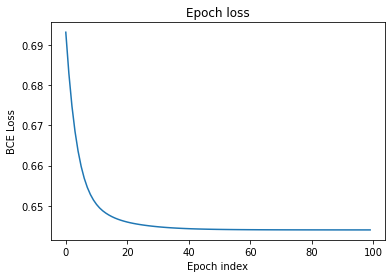

,prob,1_prob,2_prob,rest_prob,games,total_positive,total_questions
player_id,,,,,,,
224482,0.111111,0.083333,0.166667,0.083333,1.0,4.0,36.0
154072,0.429217,0.467742,0.330739,0.235294,18.0,285.0,664.0
38,0.202680,0.200000,0.168350,0.025411,12.0,121.0,597.0


In [52]:
model = LR_PlayerWeights()

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

losses = train(100)
# Comparison with historical average probabilities
players_probabilities.loc[player_id_sample]

---
#### Logistic Regression with Player & Question weights

- `model.player` will be a hidden variable which describes the player.  
- `model.questions` will be a hidden variable which describes complexity of the question 

Under the hood, the input features are an **id of a single player** and an **id of a single question**, thus on each sample it updates 2 weights (`model.player.weight[0, p_idx]` and `model.player.question[0, q_idx]`). Using this approach the model can distinguish the complexity of a question (in comments I call it `question simplicity bonus`) and the skill of a player.  

It works pretty well and allows to: 
- interpret question complexity  $P(Q_i)$
- get the probability of a person to answer specific question: $P(Q_i|P_j)$
- gain a kind of real player and question ranking  

See the **study** section after training.   

As a possible drawback - the values of very often questions are updated more frequently, which can cause lowering of their values, but the rare questions may be dramastically large (_not sure about that_). 

In [53]:
class LR_PlayerQuestionWeights(torch.nn.Module):
    def __init__(self, player_weights=None, question_weights=None):
        super(LR_PlayerQuestionWeights, self).__init__()
        self.player = torch.nn.Linear(players_probabilities.index[-1] + 1, 1, bias=False)
        if player_weights:
            self.linear.weight[:, 0] = player_weights
            
        self.questions = torch.nn.Linear(total_questions, 1, bias=False)
        if question_weights:
            self.questions.weight[:, 0] = question_weights
            
    def get_weight(self, idxs):
        idxs = torch.tensor(idxs)
        return self.player.weight[0, idxs]
        
    def forward(self, player_idxs, question_idxs):
        assert player_idxs.shape == question_idxs.shape, 'Shapes of players and questions differ'
        player_coefs = self.player.weight[0, player_idxs]
        question_coefs = self.questions.weight[0, question_idxs]
        
        result = player_coefs + question_coefs 
        
        return F.sigmoid(result)

In [54]:
def train_with_questions(epochs=100, plot=True):
    
    input = (torch.tensor([player_id_sample]), torch.tensor([question_id_sample]))
    
    with torch.no_grad():
        print('Weights before: ', model.get_weight(player_id_sample))
        print('Probs for questions before: ', model(*input))
    
    losses = []
    for epoch in tqdm_notebook(range(epochs), total=epochs):
        model.train()

# Uncomment and replace LBFGS optimizer with Adam
#         optimizer.zero_grad()
#         y_pred = model(indices, question_indices).squeeze(0)
#         total_loss = criterion(y_pred, labels)
#         losses.append(total_loss.item())
#         total_loss.backward()
#         optimizer.step()
        optimizer.step(lambda: closure(losses)) # LBFGS



    with torch.no_grad():
        print('Weights after: ', model.get_weight(player_id_sample))
        print('Probs for questions after: ', model(*input))
    
    if plot:
        plt.title('Train loss')
        plt.plot(range(len(losses)), losses)
        plt.xlabel('Epoch index')
        plt.ylabel('BCE Loss')
        plt.show()
    return losses

Weights before:  tensor([ 0.0011, -0.0004,  0.0007])
Probs for questions before:  tensor([[0.4990, 0.4993, 0.4994]])



Weights after:  tensor([-1.1418,  0.5763, -0.4197])
Probs for questions after:  tensor([[0.1468, 0.5027, 0.3145]])


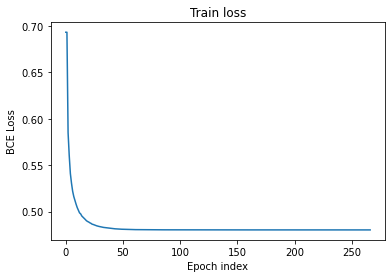

In [55]:
model = LR_PlayerQuestionWeights()

l2_term = 0
criterion = torch.nn.BCELoss()



def closure(losses): # LBFGS-specific
      predicted = model(indices, question_indices).squeeze(0)
      loss = criterion(predicted, labels)
      optimizer.zero_grad()
      losses.append(loss.item())
      loss.backward()
    
      return loss

# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
optimizer = torch.optim.LBFGS(model.parameters())

losses = train_with_questions(20)

In [56]:
# Comparison with historical average probabilities
players_probabilities.loc[player_id_sample]

,prob,1_prob,2_prob,rest_prob,games,total_positive,total_questions
player_id,,,,,,,
224482,0.111111,0.083333,0.166667,0.083333,1.0,4.0,36.0
154072,0.429217,0.467742,0.330739,0.235294,18.0,285.0,664.0
38,0.202680,0.200000,0.168350,0.025411,12.0,121.0,597.0


Questions complexity study

In [57]:
# question simplicity bonus
# expected interpretation - lower the value, harder it is to give correct answer
with torch.no_grad():
    print(f'Questions simplicity {question_id_sample}:', model.questions.weight[0, question_id_sample])

Questions simplicity [31807, 7440, 23771]: tensor([-0.6181, -0.5656, -0.3595])


In [58]:
for question_id in question_id_sample:
    print_question_info(question_id)

Question [31807] was answered correcly [46.70%] times and
belongs to tournament [6144], which also has question from [range(31807, 31843)]
Question [7440] was answered correcly [17.86%] times and
belongs to tournament [5447], which also has question from [range(7416, 7476)]
Question [23771] was answered correcly [66.50%] times and
belongs to tournament [5845], which also has question from [range(23748, 23793)]


In [59]:
del samples # free some memory

### Player ratings (Baseline-2)
Seems natural

In [60]:
raw_weights = model.player.weight.detach().cpu()
player_indices = players_probabilities.index.values
indexed_coefs = raw_weights[0, player_indices]
best_scores, best_indices = torch.sort(indexed_coefs, descending=True)
best_player_ids = player_indices[best_indices]

In [61]:
for idx, id in enumerate(best_player_ids[:20]):
    player = players[id]
    positives, total = players_probabilities.loc[id, ['total_positive', 'total_questions']]
    print(f'{idx + 1}. ({id}) {player["surname"]}  {player["name"]} {player["patronymic"]}; Ratio: [{positives:.0f}/{total:.0f}] ; weight: {best_scores[idx].item():.4f}')

1. (36844) Щербина  Павел Константинович; Ratio: [35/36] ; weight: 4.5785
2. (27403) Руссо  Максим Михайлович; Ratio: [1980/2474] ; weight: 3.7141
3. (4270) Брутер  Александра Владимировна; Ratio: [2409/3026] ; weight: 3.5807
4. (28751) Семушин  Иван Николаевич; Ratio: [3242/4118] ; weight: 3.5481
5. (40411) Кудинов  Дмитрий Сергеевич; Ratio: [33/45] ; weight: 3.4352
6. (30152) Сорожкин  Артём Сергеевич; Ratio: [4000/5254] ; weight: 3.3690
7. (30270) Спешков  Сергей Леонидович; Ratio: [3202/4190] ; weight: 3.3681
8. (27822) Савченков  Михаил Владимирович; Ratio: [2843/3677] ; weight: 3.3633
9. (38175) Пилипенко  Максим Игоревич; Ratio: [29/36] ; weight: 3.3573
10. (202410) Подюкова  Валентина ; Ratio: [33/36] ; weight: 3.2643
11. (18036) Левандовский  Михаил Ильич; Ratio: [1132/1560] ; weight: 3.2365
12. (20691) Мереминский  Станислав Григорьевич; Ratio: [1279/1739] ; weight: 3.2345
13. (22799) Николенко  Сергей Игоревич; Ratio: [1548/2325] ; weight: 3.2202
14. (26089) Прокофьева  Ирин

In [62]:
raw_weights_np = model.player.weight.detach().cpu().numpy()[0] # [1, N] -> [N]
train_only_weights = raw_weights_np[player_ids][0] 
mean_vector = train_only_weights.mean()

### Distribution of player skills

count    59101.000000
mean        -0.767763
std          1.758196
min        -15.441506
25%         -1.834444
50%         -0.537560
75%          0.461837
max          4.578496
dtype: float64


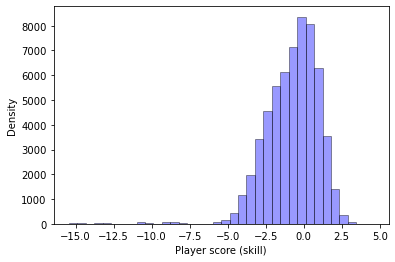

In [63]:
print(pd.Series(train_only_weights).describe())
sns.distplot(train_only_weights, hist=True, kde=False, 
             bins=180//5, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.xlabel('Player score (skill)')
plt.ylabel('Density')
plt.show()

### Team ranking

In [64]:
def estimate_tournaments_v2(tournament_ids, player_coefs: np.array, vector_policy):
    correlations = []
    for tour_id in tqdm_notebook(tournament_ids, total=len(tournament_ids)):
        team_scores = estimate_tournament_v2(tour_id, player_coefs, vector_policy)
#         team_positions = tournament_teams[tour_id]['position']
        real_ranks = range(len(team_scores))
        corrs = get_correlations(real_ranks, team_scores)
        correlations.append(corrs)
    correlations = np.array(correlations)
    return correlations.mean(axis=0)

In [65]:
def estimate_tournament_v2(tournament_id, player_coefs: np.array, vector_policy):
    global mean_vector
    
    meta = tournament_teams[tournament_id]
    teams_initial_order = meta['order']
    team_players = [meta['teams'][id].player_ids for id in teams_initial_order]
    team_vectors = []
    for ids in team_players:
        ids = np.array(ids)
        mask = ids < len(player_coefs)
        vector = np.empty(mask.shape, dtype=np.float)
        vector[mask] = player_coefs[ids[mask]]
        vector[~mask] = mean_vector
        team_vectors.append(vector)
        
    
    team_scores = [vector_policy(vector) for vector in team_vectors]
    
#     new_order = list(zip(teams_initial_order, team_scores))
#     new_order.sort(key=lambda x: x[1], reverse=True)
#     new_order, team_scores2 = list(zip(*new_order))
    
    return team_scores

### Baseline-2. Team ratings correlations

Train: Spearmen and Kendall  
Test: Spearmen and Kendall

In [66]:
train_correlations = estimate_tournaments_v2(train_keys, raw_weights_np, np.mean)
test_correlations = estimate_tournaments_v2(test_keys, raw_weights_np, np.mean)
np.abs(train_correlations), np.abs(test_correlations)

(array([0.8483, 0.6927]), array([0.7477, 0.5865]))

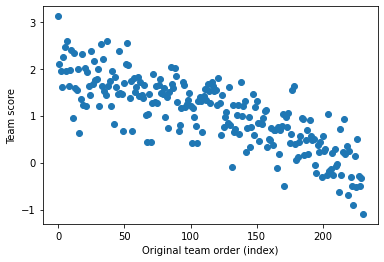

In [67]:
t = [4772, 5042, 5056, 5061, 5065]
teamscores = estimate_tournament_v2(t[0], raw_weights_np, np.mean)
plt.scatter(range(len(teamscores)), teamscores)
plt.xlabel('Original team order (index)')
plt.ylabel('Team score')
plt.show()

## 5. Question ranking

Train only tournaments



In [68]:
policy_name = 'questions toughness average'
policy = np.mean

In [69]:
question_weights = model.questions.weight.detach().cpu().numpy()[0] # (Q, )
tournament_toughness = []


for key in train_keys:
    question_ids = question_mappings[key]
    question_values = question_weights[question_ids]
    tournament_value = policy(question_values)
    
    pair = (key, tournament_value)
    tournament_toughness.append(pair)

tournament_toughness.sort(key=lambda x: x[1])
topn = 20

print('Answers provided by BASELINE-2')
print(f'Tournament evaluation POLICY: [{policy_name}]\n')

print(f'Top {topn} tough tournaments\n')
for idx, (tour_id, value) in enumerate(tournament_toughness[:topn]):
    name = tournaments[tour_id]['name']
    print(f'{idx + 1}. ({tour_id}) {name}. Toughness: [{value:.3f}]')

print('\n-----------\n')

print(f'Top {topn} most simple tournaments\n')
reverse = tournament_toughness[::-1][:topn]
for idx, (tour_id, value) in enumerate(reverse):
    name = tournaments[tour_id]['name']
    print(f'{idx + 1}. ({tour_id}) {name}. Toughness: [{value:.3f}]')

Answers provided by BASELINE-2
Tournament evaluation POLICY: [questions toughness average]

Top 20 tough tournaments

1. (6149) Чемпионат Санкт-Петербурга. Первая лига. Toughness: [-12.662]
2. (5717) Чемпионат Таджикистана. Toughness: [-4.662]
3. (5930) Зеркало мемориала памяти Михаила Басса. Toughness: [-4.503]
4. (5684) Синхрон высшей лиги Москвы. Toughness: [-4.225]
5. (6101) Воображаемый музей. Toughness: [-4.062]
6. (5435) Шестая октава: СИ-Мажор. Лига Наций: Прибалтика. Toughness: [-4.038]
7. (5427) День D. Toughness: [-4.017]
8. (5532) Седьмая октава: Кубок Равноденствия. Лига Наций: Прибалтика. Toughness: [-4.001]
9. (5928) Угрюмый Ёрш. Toughness: [-3.905]
10. (5929) Мемориал памяти Михаила Басса. Toughness: [-3.878]
11. (5384) Поволжская лига. Toughness: [-3.799]
12. (5943) Чемпионат Мира. Этап 2 Группа С. Toughness: [-3.725]
13. (5159) Первенство правого полушария. Toughness: [-3.721]
14. (5415) Главные вопросы жизни, вселенной и всего такого. Онлайн. Toughness: [-3.655]
15. 

In [70]:
del question_weights
del tournament_toughness
del reverse
del raw_weights

## 4. CHGK as a team game


### Preparation

1. Get each pair of (team -> question)  
2. The label of a pair is variable $Z$, which determines the likelihood $\in (0;1)$ the $Team_j$ answers $Question_i$.  
3. Get indexes of known pairs (which teams answered). It will be $Z_{ij}$, where the real label is known ($Y_i$ = 0 or 1 for $Team_j$).  
4. The rest of pairs are unknown and will be preliminary set to $Z_{ij}^{(0)} = \mathop{\mathbb{E}}(Y_i)$  

### On each iteration

1. Set labels to the values of $Z_{ij}$, where real $Y_{ij}$ is unknown; use $Y_{ij}$ otherwise.   
2. Train logistic/linear regression with parameters: question difficulty, player skill.  
  - On each sample the inputs are indexes of team members and question id.  
  - The output of a sample is $\sigma[\sum_{j\in{team_i}}(W^{player}_{j}) + W^{question}_{k}]$  
3. Get values of $Z_{i}$ as the new values of trained model.  
4. Go to step (1) until $Q(Z, Z^{'}) < EPS$



In [71]:
def row_to_team_sample(row, columns=['tournament_id', 'team_id', 'question_id', 'label']):
    mask = row['mask']
    N = len(mask)
    tour_id = row.tournament_id
    idxs = list(question_mappings[tour_id])
    labels = mask_to_labels.get((tour_id, mask), None)
    
    if labels is None:
        labels = [c_to_int[c] for c in mask]
        mask_to_labels[(tour_id, mask)] = labels
    
    samples = pd.DataFrame(zip([tour_id] * N, [row.team_id] * N, idxs[:N], labels), columns=columns)
    return samples

def team_tour_to_players(df):
    teamtour_to_players = {}
    team_to_tours = defaultdict(list)
    for idx, row in df.iterrows():
        members = [meta[0] for meta in row['members']]
        team_id = row['team_id']
        teamtour_to_players[(idx, team_id)] = members
        team_to_tours[team_id].append(idx)
        
    return teamtour_to_players, team_to_tours

In [72]:
train_teams_df = teams_df[teams_df.tournament_id.isin(train_keys)]
team_question_df = train_teams_df[['tournament_id', 'team_id', 'mask', 'members']]
team_question_df.sample(3)

,tournament_id,team_id,mask,members
tournament_id,,,,
5554,5554,70338,001000000000010110000000000000000000000100110,"[(118508, 0, 2987), (142090, 0, 7951), (171916..."
5756,5756,57900,01001000011X100010X00000111000000X10,"[(87044, 10013, 10013), (102751, 7591, 9109), ..."
5475,5475,62078,1111011010000010101110110100001101110111001001...,"[(131810, 569, 569), (162050, 466, 559), (1688..."


In [73]:
# Same team in different tournaments can switch players
# (tour_id, team_id)
teamtour_to_players, team_to_tours = team_tour_to_players(team_question_df)
team_id = 62070
played = team_to_tours[team_id]

print(f'Team {team_id} participated in', played)
for tour_id in played[:2]:
    print(f'Team {team_id} in tour {tour_id}', teamtour_to_players[(tour_id, team_id)])

Team 62070 participated in [4973, 4974, 4975, 4986, 5021, 5025, 5074, 5078, 5108, 5129, 5163, 5205, 5314, 5358, 5443, 5444, 5554, 5557, 5648, 5760, 5761, 5833, 5864, 5880]
Team 62070 in tour 4973 [147738, 162020, 13658, 167372]
Team 62070 in tour 4974 [147738, 162020, 115524, 31817, 13658]


In [75]:
team_train_samples = team_question_df.apply(row_to_team_sample, axis=1)
team_train_samples = pd.concat(list(team_train_samples))

print(team_train_samples.shape)
team_train_samples.sample(3)

(3822540, 4)


,tournament_id,team_id,question_id,label
15,5864,27522,24335,1
9,5629,43002,15543,1
27,5718,62365,18996,1


In [76]:
question_stats = team_train_samples.groupby('question_id').apply(lambda x: x['label'].mean())
question_stats.sample(3)

question_id
8391     0.862500
24222    0.485849
19372    0.237232
dtype: float64

In [77]:
from sklearn.linear_model import LinearRegression as LR
from scipy.sparse import csr_matrix

In [78]:
player_shift = player_ids.max().item() # bcs it was torch
def generate_csr_matrix(indices, question_indices):
    data = []
    row = []
    cols = []
    for idx, (pair, qid) in enumerate(zip(indices, question_indices)):
        players = teamtour_to_players[pair]
        for player in players:
            row.append(idx)
            cols.append(player)
            data.append(1)
        row.append(idx)
        cols.append(player_shift + qid)
        data.append(1)
    row, cols, data = map(np.array, [row, cols, data])
    return csr_matrix((data, (row, cols)))

def sigmoid(x):
    ex = np.exp(x)
    return ex / (1 + ex)

def M_step(X, Z, plot=True):
    
    model = LR().fit(X, Z)
    preds = model.predict(X)
    return model, preds

def E_step(Z, Z_new):
    Z_upd = np.ones(Z.shape, dtype=np.float)
    Z_upd[correct_answers_mask] = Z[correct_answers_mask]
    Z_upd[incorrect_answers_mask] = Z_new[incorrect_answers_mask]
    return Z_upd

In [79]:
correct_answers_mask = team_train_samples.label == 1
incorrect_answers_mask = ~correct_answers_mask
# todo: find pi_0 and pi_1 per (tour_id, team)

Z_initial = np.ones(correct_answers_mask.shape)
# Z_initial[incorrect_answers_mask] = question_stats[team_train_samples[incorrect_answers_mask].index]
Z_initial[incorrect_answers_mask] = 0

Z_initial = np.clip(Z_initial, 1e-8, 1-1e-8)

Z = Z_initial
Z = np.log(Z / (1 - Z))

In [80]:
question_indices = team_train_samples['question_id'].values
indices = list(zip(team_train_samples.tournament_id, team_train_samples.team_id))
matrix = generate_csr_matrix(indices, question_indices)


Correlations: [0.6532 0.492 ]


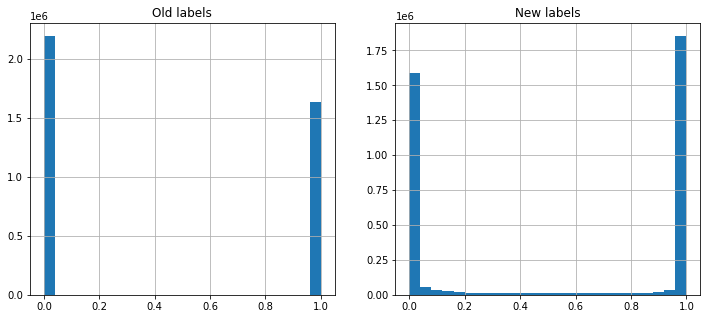


Correlations: [0.6394 0.4832]


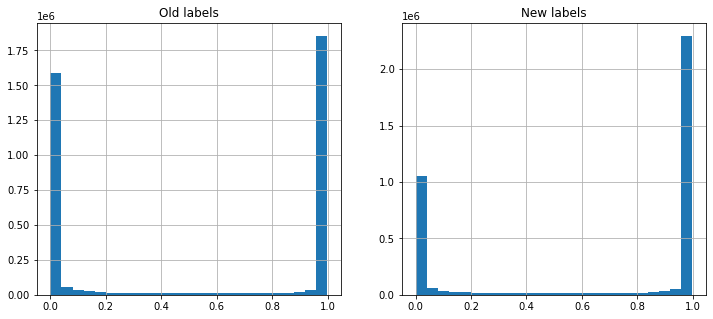


Correlations: [0.6149 0.4643]


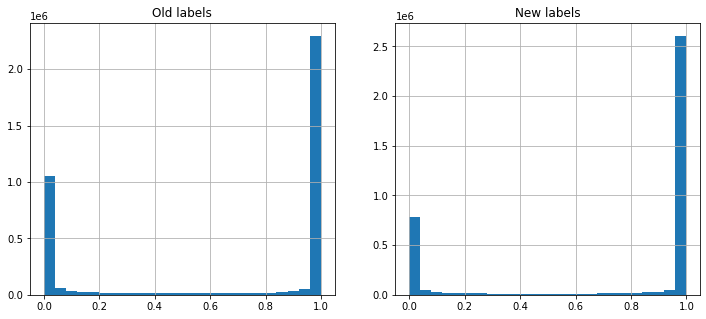


Correlations: [0.5874 0.4427]


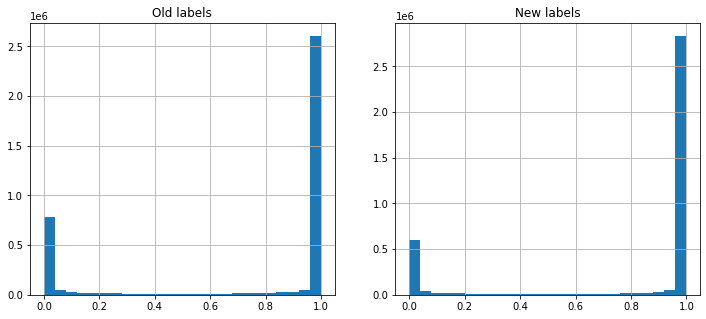


Correlations: [0.5698 0.4298]


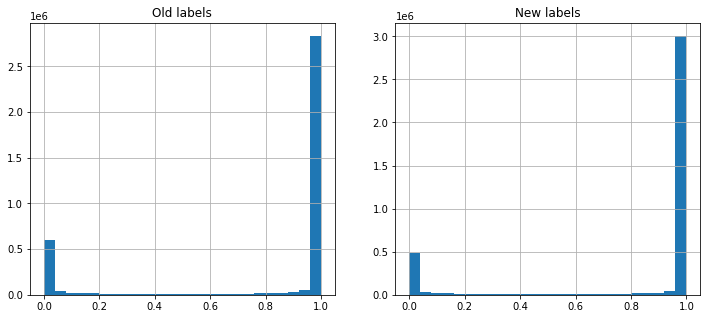

In [81]:
labels_old = Z_initial
models = []
scores = []
for i in tqdm_notebook(range(5), total=5):
    model, predictions = M_step(matrix, Z)
    local_weights = model.coef_
    mean_vector = model.coef_[player_indices].mean()

    test_correlations = estimate_tournaments_v2(test_keys, local_weights, np.mean)
    print('Correlations:', np.abs(test_correlations)) # Spearmen and Kendall
    
    models.append(model)
    scores.append(test_correlations)

    Z_new = E_step(Z, predictions) 
    labels = sigmoid(np.clip(Z_new, -10, 6.5))


    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    for ax, arr, title in zip(axs, [labels_old, labels], ['Old labels', 'New labels']):
        pd.Series(arr).hist(ax=ax, bins=25)
        ax.set(title=title)
    plt.show()
    labels_old = labels
    Z = Z_new